<a href="https://colab.research.google.com/github/MatthewK84/Python-Code/blob/main/Rain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install statsforecast -U

In [2]:
import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm
import plotly
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, AutoTheta, AutoCES
from scipy.stats import pearsonr

rain = pd.read_csv("/content/rain1.csv")
data = pd.read_csv("/content/Data.csv")
data.head()

,Year,ISMR,Ind_Ocean,Nth_Atlantic,Sth_Atlantic,Equatorial_Pacific,Nino34
0,1871,0.007220,0.0333,0.0941,0.2066,-0.1308,-0.303064
1,1872,0.788207,0.0871,0.1803,0.1773,0.1232,-0.557821
2,1873,-1.092659,-0.4395,-0.1859,-0.1706,-0.3014,-0.322683
3,1874,1.521059,-0.0882,0.0533,0.1576,0.0276,-0.863519
4,1875,0.981949,-0.4571,0.2312,0.1340,-0.8364,-0.707591


In [3]:
rain.head()

,Year,Z
0,1871,0.007220
1,1872,0.788207
2,1873,-1.092659
3,1874,1.521059
4,1875,0.981949


In [4]:
rain.describe()

,Year,Z
count,146.000000,146.000000
mean,1943.500000,0.000750
std,42.290661,1.004239
min,1871.000000,-2.937425
25%,1907.250000,-0.659747
50%,1943.500000,0.125752
75%,1979.750000,0.690132
max,2016.000000,2.070999


In [6]:
result_df = data.merge(rain, on='Year', how='right')
result_df.head()

,Year,ISMR,Ind_Ocean,Nth_Atlantic,Sth_Atlantic,Equatorial_Pacific,Nino34,Z
0,1871,0.007220,0.0333,0.0941,0.2066,-0.1308,-0.303064,0.007220
1,1872,0.788207,0.0871,0.1803,0.1773,0.1232,-0.557821,0.788207
2,1873,-1.092659,-0.4395,-0.1859,-0.1706,-0.3014,-0.322683,-1.092659
3,1874,1.521059,-0.0882,0.0533,0.1576,0.0276,-0.863519,1.521059
4,1875,0.981949,-0.4571,0.2312,0.1340,-0.8364,-0.707591,0.981949


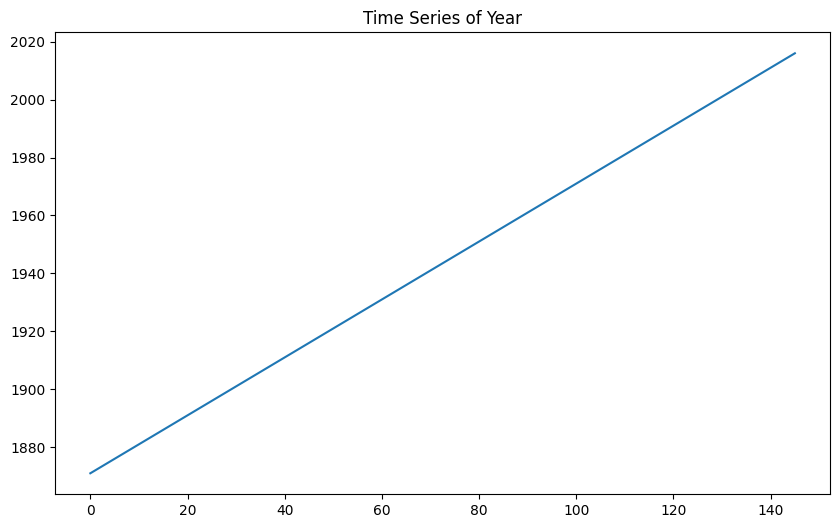

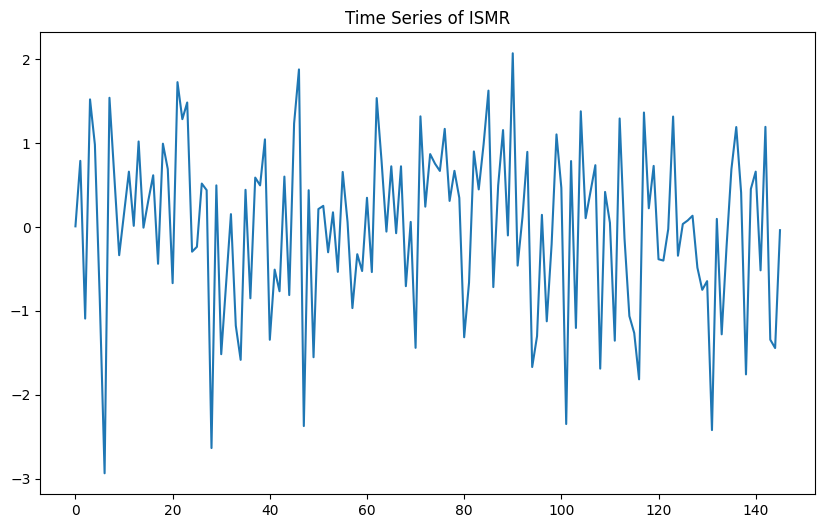

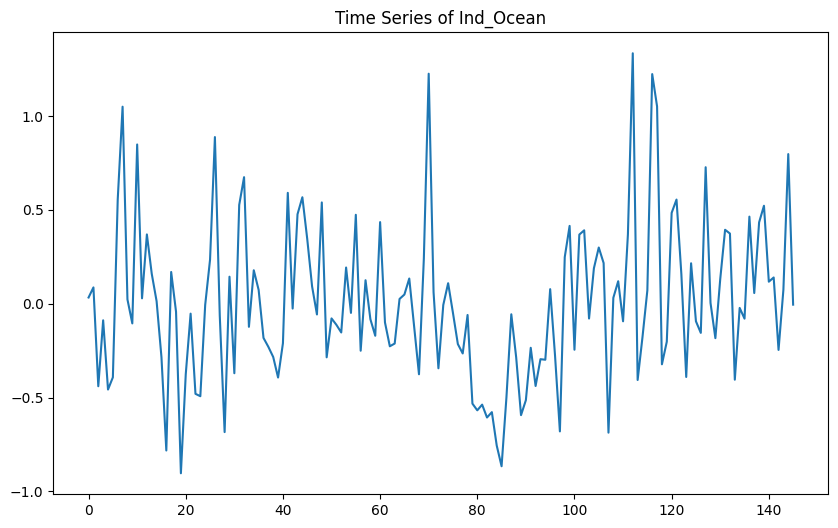

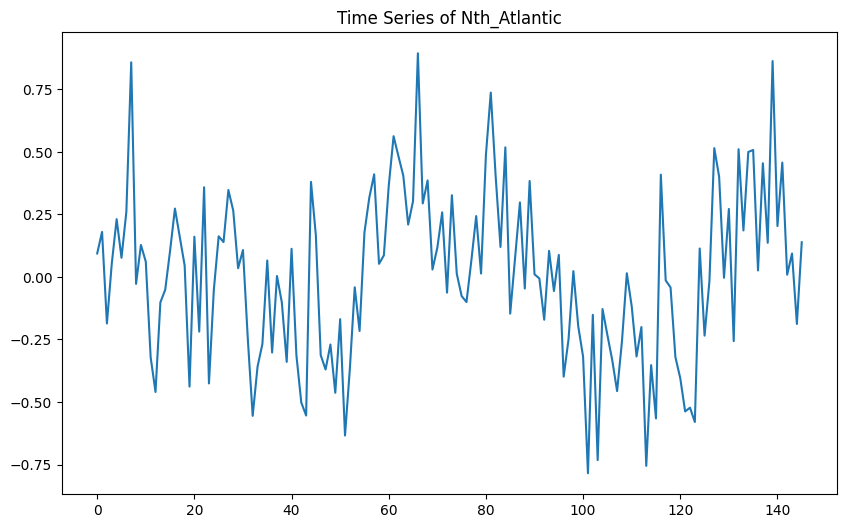

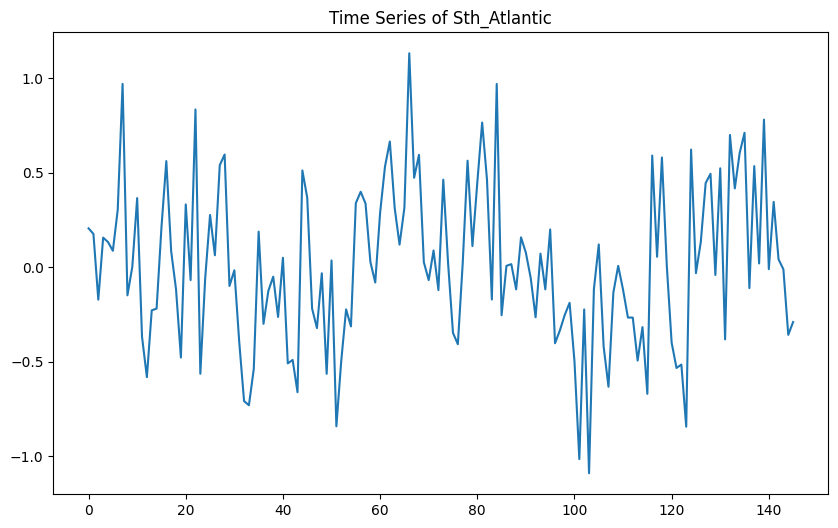

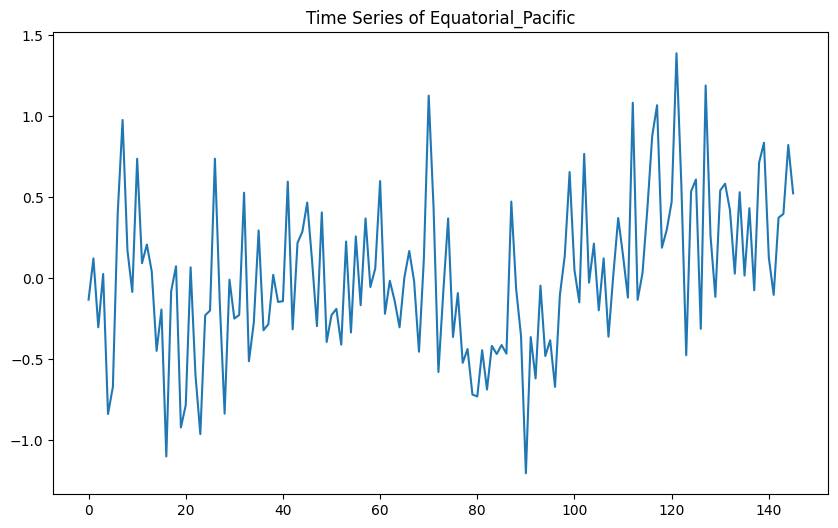

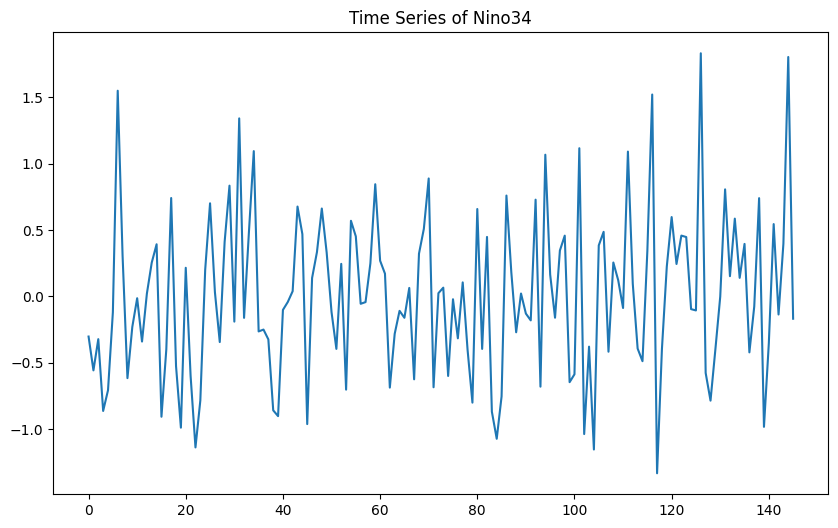

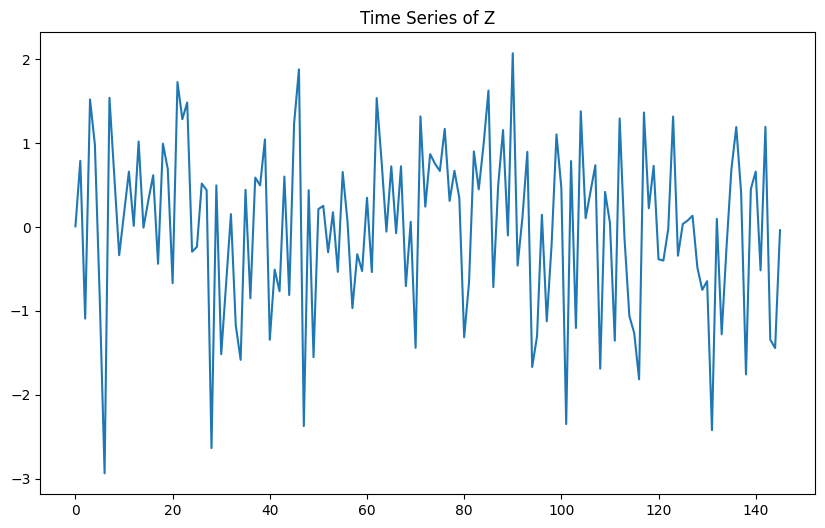

                   stationary missing_values
ISMR                     True              0
Ind_Ocean                True              0
Nth_Atlantic             True              0
Sth_Atlantic             True              0
Nino34                   True              0
Z                        True              0
Year                    False              0
Equatorial_Pacific      False              0


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Check for stationarity
def check_stationarity(series):
    result = adfuller(series.dropna())  # dropna() handles missing values
    p_value = result[1]
    return p_value <= 0.05  # a p-value less than 0.05 suggests stationarity

# Check for missing values
def check_missing_values(series):
    return series.isnull().sum()

# Plotting function
def plot_series(series, title):
    series.plot(figsize=(10, 6))
    plt.title(title)
    plt.show()

# Assume we have a list of possible y_variables in the DataFrame
y_variables = result_df.columns

# Analysis results dictionary
analysis_results = {}

for y_var in y_variables:
    series = result_df[y_var]

    # Check for stationarity
    stationary = check_stationarity(series)

    # Check for missing values
    missing_values = check_missing_values(series)

    # Store results
    analysis_results[y_var] = {
        'stationary': stationary,
        'missing_values': missing_values
    }

    # Plot the series
    plot_series(series, f'Time Series of {y_var}')

# Convert the analysis results to a DataFrame for easier comparison
analysis_df = pd.DataFrame(analysis_results).T

# Sort by 'stationary' True and fewer 'missing_values'
sorted_analysis_df = analysis_df.sort_values(by=['stationary', 'missing_values'], ascending=[False, True])

print(sorted_analysis_df)

In [10]:
#Calculate the correlation between Nino34 and ISMR
correlation = result_df['Nino34'].corr(result_df['ISMR'])
print(f"The correlation between Nino34 and ISMR is: {correlation:.4f}")

The correlation between Nino34 and ISMR is: -0.5791


In [11]:
# Calculate the correlation matrix
correlation_matrix = result_df.corr()

# Display the correlation matrix with Nino34 as the dependent variable
correlation_matrix_nino34 = correlation_matrix[['Nino34']].sort_values(by='Nino34', ascending=False)

correlation_matrix_nino34

,Nino34
Nino34,1.000000
Ind_Ocean,0.301688
Year,0.128665
Equatorial_Pacific,0.064938
Nth_Atlantic,-0.089119
Sth_Atlantic,-0.121626
ISMR,-0.579090
Z,-0.579090


In [17]:
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    CrostonClassic as Croston,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)

In [19]:
# Drop all columns except for 'Year', 'unique_id', and 'Nino34'
# Then rename the columns as specified
transformed_df = result_df.reset_index()[['Year', 'Nino34']].copy()
transformed_df.rename(columns={'Year': 'ds', 'Nino34': 'y'}, inplace=True)

# Add a 'unique_id' column which will be the row number
transformed_df.insert(0, 'unique_id', range(1, 1 + len(transformed_df)))

# Display the transformed dataframe
transformed_df.head()

,unique_id,ds,y
0,1,1871,-0.303064
1,2,1872,-0.557821
2,3,1873,-0.322683
3,4,1874,-0.863519
4,5,1875,-0.707591


In [ ]:
!pip install pmdarima

In [32]:
from pmdarima import auto_arima

# Assuming 'nino34_series' is a pandas Series of the Nino34 variable
nino34_series = result_df['Nino34'].dropna()  # Make sure there are no NaN values

# Use auto_arima to find the best ARIMA model
auto_arima_model = auto_arima(nino34_series, start_p=1, start_q=1,
                              test='adf',       # use adftest to find optimal 'd'
                              max_p=3, max_q=3, # maximum p and q
                              m=1,              # frequency of series
                              d=None,           # let model determine 'd'
                              seasonal=False,   # No Seasonality
                              start_P=0,
                              D=0,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=275.836, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=273.335, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=275.327, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=275.325, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=275.334, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.754 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  146
Model:                        SARIMAX   Log Likelihood                -135.668
Date:                Tue, 07 Nov 2023   AIC                            273.335
Time:                        20:01:49   BIC                            276.319
Sample:                             0   HQIC                           274.547
                                - 146                                         
Co

**Model Fit Summary:**

The selected model was fitted to a total of 146 observations.
The log-likelihood of the model is -135.668.
The AIC, which balances model fit against complexity, is 273.335. A lower AIC suggests a better model fit relative to models with a higher AIC.
The Bayesian Information Criterion (BIC) is 276.319, and the Hannan-Quinn Information Criterion (HQIC) is 274.547. These are additional metrics for model comparison, where again, lower values suggest a better model fit.
Model Coefficients:

Since the model is ARIMA(0,0,0), there are no AR or MA coefficients, only the variance of the residuals (sigma^2), which is estimated to be 0.3755. The standard error of this estimate is 0.042, and the z-score is 8.978, which is highly significant (p-value < 0.0001). This indicates strong evidence that the variance is different from zero.

**Diagnostic Tests:**

The Ljung-Box test result (Q-statistic) at lag 1 is 0.01 with a p-value of 0.93, suggesting that the residuals are independently distributed over time (no autocorrelation).
The Jarque-Bera test result for normality of residuals is 4.29 with a p-value of 0.12, indicating that there's no strong evidence against the normality assumption of residuals.
The model exhibits a slight skewness of 0.41 but has an almost normal kurtosis of 3.20, indicating that the distribution of residuals is fairly symmetrical and has a peak similar to that of a normal distribution.
The heteroskedasticity test gives a ratio of 1.25 with a p-value of 0.44, suggesting that there is no strong evidence of heteroskedasticity, meaning the variance of the residuals does not appear to change over time.

**Warnings:**

A warning is issued stating that the covariance matrix is calculated using the outer product of gradients. This is a technical note indicating the method used for estimating the uncertainty in the model parameters and is common when the model has no regressors.

**Overall Interpretation:**

The best-fitting model according to AIC is a simple white noise model, which indicates that past values are not useful in predicting future values of the series with any significant degree of accuracy. This could imply that the time series is a random walk, that the time series is not well-modeled by linear ARIMA processes, or that important explanatory variables are missing from the model. Further analysis might involve exploring more complex models, considering the inclusion of external regressors, or examining non-linear relationships.

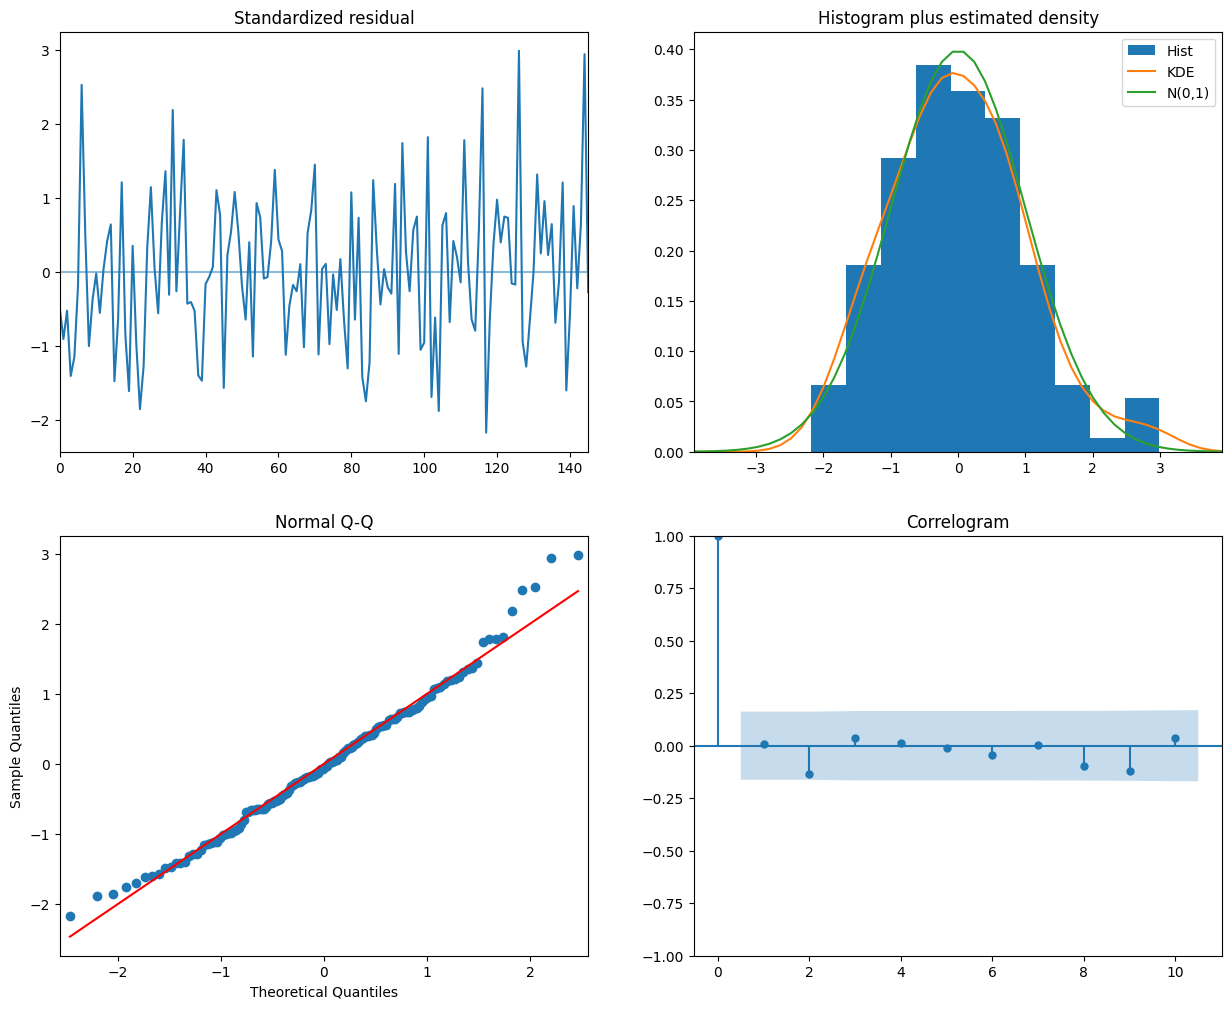

In [36]:
import statsmodels.api as sm

# Plot the residuals
auto_arima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [38]:
y = result_df['ISMR'].dropna()  # Ensure there are no NaN values

# Fit a seasonal ARIMA model
# Here, m is the number of periods in one season, for example, 12 for monthly data with yearly seasonality
# D is the order of seasonal differencing
# If you don't have seasonal data, you can set m=1 which essentially ignores seasonal components

sarimax_model = auto_arima(y, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

# The 'sarimax_model' variable now holds the trained model

# To make predictions, you can use:
n_periods = 5  # For example, if you want to predict 5 periods into the future
forecast, conf_int = sarimax_model.predict(n_periods=n_periods, return_conf_int=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.91 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=580.104, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=499.052, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=537.150, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=484.593, Time=0.35 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.24 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=536.277, Time=0.20 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=461.429, Time=0.39 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=475.402, Time=0.17 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.20 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.41 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=460.260, Time=0.49 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=475.549, Time=

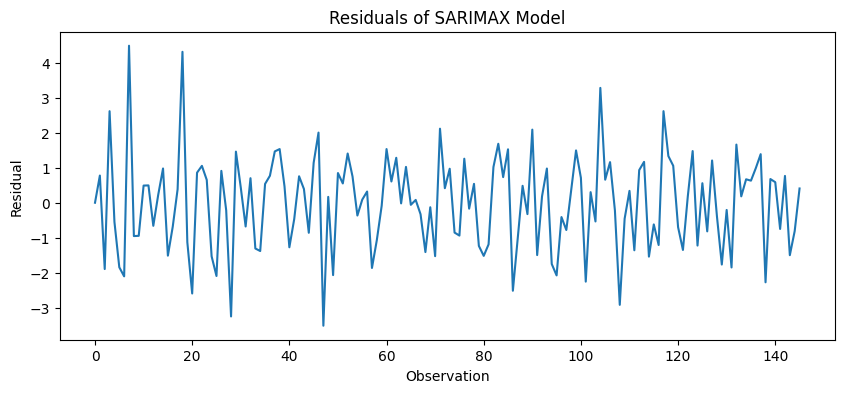

In [39]:
# Get residuals
residuals = sarimax_model.resid()

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals of SARIMAX Model')
plt.xlabel('Observation')
plt.ylabel('Residual')
plt.show()